In [1]:
#This section links the notebook to the project root directory
import sys,os

nb_path = os.path.abspath('')
print("Current Path:", nb_path)

#get root working directory, link to notebook
PROJ_ROOT = os.path.abspath(os.path.join(nb_path,'..','..'))
print("Project Root:", PROJ_ROOT)
if PROJ_ROOT not in sys.path:
    sys.path.insert(0,PROJ_ROOT)

Current Path: c:\Users\tsamb\OneDrive\Desktop\ECS 171 Project\project\models\mlp
Project Root: c:\Users\tsamb\OneDrive\Desktop\ECS 171 Project\project


In [2]:
#Getting data, including preprocessing if necessary
from data_preprocess import preprocess

#get directory, and X.npy and y.npy
raw_dir_training = os.path.join(PROJ_ROOT, "dataset", "seg_train", "seg_train")
raw_dir_test = os.path.join(PROJ_ROOT,"dataset","seg_test","seg_test")
Xtrain_path,ytrain_path = 'Xtrain.npy','ytrain.npy'
Xtest_path,ytest_path = 'Xtest.npy','ytest.npy'

#check if npy training files exist
#if files do not exist, they will be created
##NOTE: doing so will use ~4.5GB of data, so please make sure they are
## in the correct directory so they are not reproduced.
print("Checking if training files exist...")
if not os.path.exists(Xtrain_path) or not os.path.exists(ytrain_path):
    print("Not found, now preprocessing training imgs...")
    preprocess(
        input_dir=raw_dir_training,
        target_size=(150,150),
        out_X="Xtrain.npy",
        out_y="ytrain.npy"
    )
    print("Finished preprocessing training! (Finished files may be in root. Please move to mlp folder.)")
else:
     print("Training files found!")

#check if npy test files exist
print("Checking if test files exist...")
if not os.path.exists(Xtest_path) or not os.path.exists(ytest_path):
    print("Not found, now preprocessing test imgs...")
    preprocess(
        input_dir=raw_dir_test,
        target_size=(150,150),
        out_X="Xtest.npy",
        out_y="ytest.npy"
    )
    print("Finished preprocessing test! (Finished files may be in root. Please move to mlp folder.)")
else:
    print("Test files found!")

Checking if training files exist...
Training files found!
Checking if test files exist...
Test files found!


In [3]:
#The interesting stuff, making the model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Load datasets from folder and print their shape
Xtrain,ytrain = np.load(Xtrain_path), np.load(ytrain_path)
print("X shape:", Xtrain.shape, "y shape:", ytrain.shape)

#Defining the function for the modelab
#making the MLP, using ReLU then softmax
def make_mlp(num_hidden=2,num_neurons=256,lr=0.001,dropout_rate=0.2):
    print("Making model")
    model = Sequential()

    #Input Layer
    model.add(Dense(num_neurons, activation='relu',input_shape=(67500,)))
    model.add(Dropout(dropout_rate))

    #Hidden layers, number of neurons decrease by half each layer
    for i in range(num_hidden):
        num_neurons = (num_neurons / 2)
        model.add(Dense(num_neurons, activation='relu')) #relu activation
        model.add(Dropout(dropout_rate))
    
    #Final output layer, with y outputs. softmax activator.
    model.add(Dense(len(np.unique(ytrain)), activation='softmax')) #output layer, using features from y, softmax for multiple classes

    #compile the model and get summary
    #Adam is used as optimizer for cleaner tuning
    #Loss is measured as sparse_categorical_crossentropy since data is not one hot encoded
    #And with multiple classes
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

testModel = make_mlp()
testModel.summary()

X shape: (14034, 67500) y shape: (14034,)
Making model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               17280256  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 

In [4]:
#Here the model is tested with a smaller data set and tuned accordingly.
#Tuning had to be done by hand, as using GridSearchCV resulted in extremely long
#processing time and memory usage.
#Tuning by hand, with verbose on, allows for trackable progress.
#First, we halve our data to speed up tuning time

#Making smaller sample size
sample_size=int(Xtrain.shape[0]/2)
X_tune,y_tune = Xtrain[:sample_size],ytrain[:sample_size]

#Getting test data
Xtest, ytest = np.load(Xtest_path),np.load(ytest_path)
test_sample_size = int(Xtest.shape[0]/2)
X_tune_test,y_tune_test = Xtest[:test_sample_size],ytest[:test_sample_size]

print("X shape:",X_tune.shape,"y shape:",y_tune.shape)
print("X test shape:",X_tune_test.shape,"y test shape:",y_tune_test.shape)


X shape: (7017, 67500) y shape: (7017,)
X test shape: (1500, 67500) y test shape: (1500,)


In [5]:
#Training model_1
#Model 1 is baseline, no changes made.
model_1 = make_mlp() #No changes
print("Fitting model_1...")
hist_model_1=model_1.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_1...
Epoch 1/10
234/234 [==============================] - 36s 150ms/step - loss: 2.5816 - accuracy: 0.4694 - val_loss: 1.0015 - val_accuracy: 0.5413
Epoch 2/10
234/234 [==============================] - 35s 150ms/step - loss: 0.9850 - accuracy: 0.5417 - val_loss: 0.8580 - val_accuracy: 0.6640
Epoch 3/10
234/234 [==============================] - 35s 150ms/step - loss: 0.9394 - accuracy: 0.5652 - val_loss: 0.7861 - val_accuracy: 0.6733
Epoch 4/10
234/234 [==============================] - 36s 155ms/step - loss: 0.9043 - accuracy: 0.5839 - val_loss: 0.7727 - val_accuracy: 0.7127
Epoch 5/10
234/234 [==============================] - 36s 153ms/step - loss: 0.8607 - accuracy: 0.6369 - val_loss: 0.7602 - val_accuracy: 0.7040
Epoch 6/10
234/234 [==============================] - 36s 153ms/step - loss: 0.8498 - accuracy: 0.6376 - val_loss: 0.7635 - val_accuracy: 0.7227
Epoch 7/10
234/234 [==============================] - 36s 153ms/step - loss: 0.8389 - accuracy: 0.

In [6]:
#Training model_2
#A dropout rate of 0.1 is used
model_2 = make_mlp(dropout_rate=0.1)
print("Fitting model_2...")
hist_model_2= model_2.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_2...
Epoch 1/10
234/234 [==============================] - 37s 153ms/step - loss: 2.3614 - accuracy: 0.5363 - val_loss: 0.8011 - val_accuracy: 0.6727
Epoch 2/10
234/234 [==============================] - 36s 155ms/step - loss: 0.9193 - accuracy: 0.5899 - val_loss: 0.7714 - val_accuracy: 0.6547
Epoch 3/10
234/234 [==============================] - 36s 153ms/step - loss: 0.8637 - accuracy: 0.6186 - val_loss: 0.8033 - val_accuracy: 0.6540
Epoch 4/10
234/234 [==============================] - 35s 152ms/step - loss: 0.8428 - accuracy: 0.6322 - val_loss: 0.7296 - val_accuracy: 0.7033
Epoch 5/10
234/234 [==============================] - 36s 153ms/step - loss: 0.7963 - accuracy: 0.6563 - val_loss: 0.7162 - val_accuracy: 0.7027
Epoch 6/10
234/234 [==============================] - 36s 153ms/step - loss: 0.7491 - accuracy: 0.6870 - val_loss: 0.7689 - val_accuracy: 0.6940
Epoch 7/10
234/234 [==============================] - 36s 153ms/step - loss: 0.7492 - accuracy: 0.

In [7]:
#Training model_3
#A learning rate of 0.0001 is used
model_3 = make_mlp(lr=0.0001)
print("Fitting model_3...")
hist_model_3 = model_3.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_3...
Epoch 1/10
234/234 [==============================] - 37s 154ms/step - loss: 1.2076 - accuracy: 0.5357 - val_loss: 0.8193 - val_accuracy: 0.6853
Epoch 2/10
234/234 [==============================] - 36s 154ms/step - loss: 0.9280 - accuracy: 0.6397 - val_loss: 0.7511 - val_accuracy: 0.7113
Epoch 3/10
234/234 [==============================] - 36s 152ms/step - loss: 0.8631 - accuracy: 0.6610 - val_loss: 0.7165 - val_accuracy: 0.7413
Epoch 4/10
234/234 [==============================] - 36s 153ms/step - loss: 0.8090 - accuracy: 0.6912 - val_loss: 0.6930 - val_accuracy: 0.7407
Epoch 5/10
234/234 [==============================] - 36s 153ms/step - loss: 0.7816 - accuracy: 0.6997 - val_loss: 0.7178 - val_accuracy: 0.7280
Epoch 6/10
234/234 [==============================] - 35s 151ms/step - loss: 0.7503 - accuracy: 0.7094 - val_loss: 0.6972 - val_accuracy: 0.7427
Epoch 7/10
234/234 [==============================] - 35s 152ms/step - loss: 0.7409 - accuracy: 0.

In [8]:
#Combining model 2 and 3
#Uses a dropout rate of 0.1 and a learning rate of 0.0001
model_4 = make_mlp(dropout_rate=0.1,lr=0.0001)
print("Fitting model_4...")
hist_model_4=model_4.fit(X_tune,y_tune,epochs=10,batch_size=30,validation_data=(X_tune_test,y_tune_test))

Making model
Fitting model_4...
Epoch 1/10
234/234 [==============================] - 36s 152ms/step - loss: 1.0762 - accuracy: 0.5810 - val_loss: 0.7739 - val_accuracy: 0.6733
Epoch 2/10
234/234 [==============================] - 36s 152ms/step - loss: 0.8328 - accuracy: 0.6745 - val_loss: 0.7155 - val_accuracy: 0.7267
Epoch 3/10
234/234 [==============================] - 36s 155ms/step - loss: 0.7551 - accuracy: 0.7046 - val_loss: 0.6915 - val_accuracy: 0.7340
Epoch 4/10
234/234 [==============================] - 36s 154ms/step - loss: 0.7360 - accuracy: 0.7121 - val_loss: 0.6992 - val_accuracy: 0.7320
Epoch 5/10
234/234 [==============================] - 36s 153ms/step - loss: 0.7161 - accuracy: 0.7258 - val_loss: 0.6709 - val_accuracy: 0.7507
Epoch 6/10
234/234 [==============================] - 35s 152ms/step - loss: 0.6795 - accuracy: 0.7391 - val_loss: 0.6763 - val_accuracy: 0.7360
Epoch 7/10
234/234 [==============================] - 36s 154ms/step - loss: 0.6517 - accuracy: 0.

Model Loss Visualization


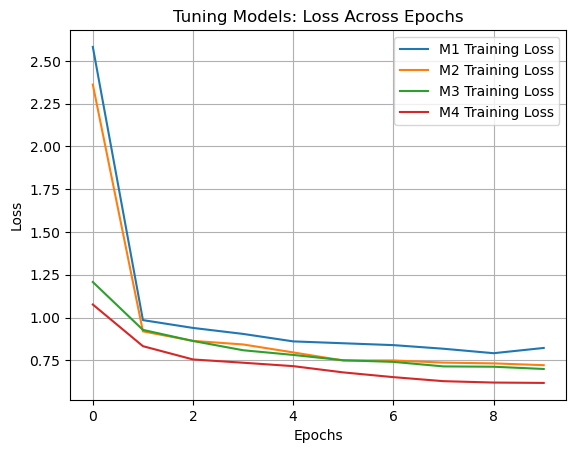

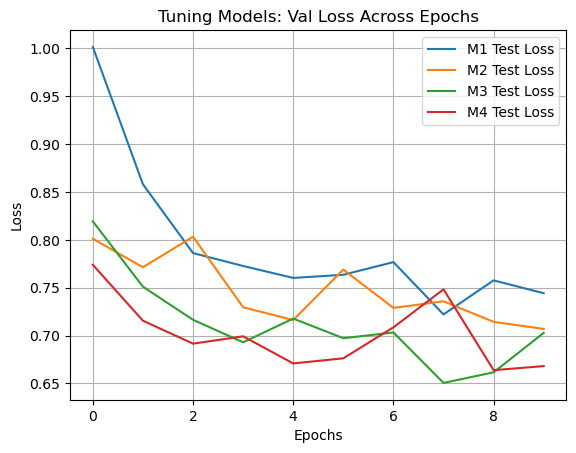

Model with consistently lower loss is model_4


In [9]:
import matplotlib.pyplot as plt

print("Model Loss Visualization")
plt.plot(hist_model_1.history['loss'], label='M1 Training Loss')
plt.plot(hist_model_2.history['loss'], label='M2 Training Loss')
plt.plot(hist_model_3.history['loss'], label='M3 Training Loss')
plt.plot(hist_model_4.history['loss'], label='M4 Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()


plt.plot(hist_model_1.history['val_loss'],label='M1 Test Loss')
plt.plot(hist_model_2.history['val_loss'],label='M2 Test Loss')
plt.plot(hist_model_3.history['val_loss'],label='M3 Test Loss')
plt.plot(hist_model_4.history['val_loss'],label='M4 Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Val Loss Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

print("Model with consistently lower loss is model_4")

Model Accuracy Visualization


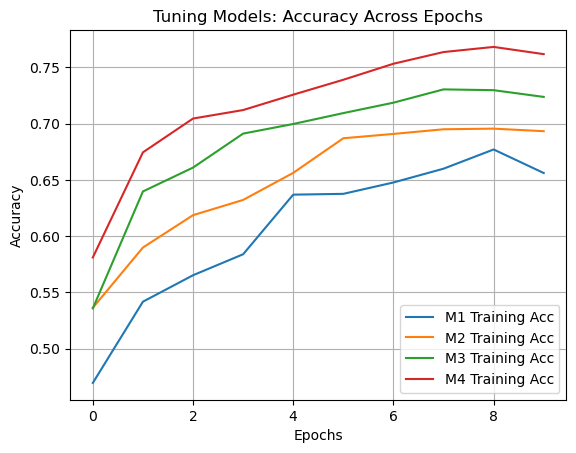

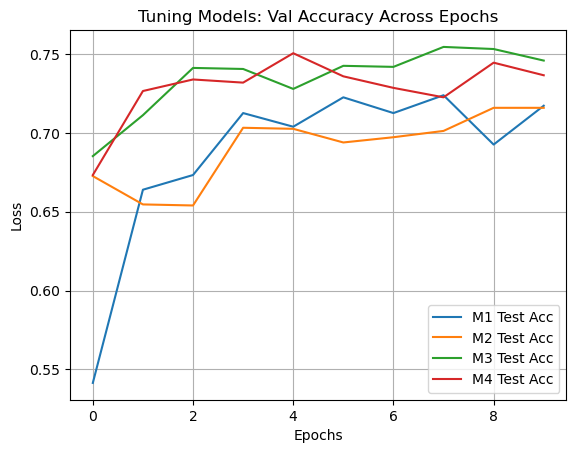

Model with higher accuracy is model_4 with validation accuracy shaking somewhat in comparison to model_2, but converging to nearly the same final accuracy.


In [10]:
print("Model Accuracy Visualization")
plt.plot(hist_model_1.history['accuracy'], label='M1 Training Acc')
plt.plot(hist_model_2.history['accuracy'], label='M2 Training Acc')
plt.plot(hist_model_3.history['accuracy'], label='M3 Training Acc')
plt.plot(hist_model_4.history['accuracy'], label='M4 Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Tuning Models: Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()


plt.plot(hist_model_1.history['val_accuracy'],label='M1 Test Acc')
plt.plot(hist_model_2.history['val_accuracy'],label='M2 Test Acc')
plt.plot(hist_model_3.history['val_accuracy'],label='M3 Test Acc')
plt.plot(hist_model_4.history['val_accuracy'],label='M4 Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Tuning Models: Val Accuracy Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

print("Model with higher accuracy is model_4 with validation accuracy shaking somewhat in comparison to model_2, but converging to nearly the same final accuracy.")

In [11]:
#Training model_5
#Epoch size of 15 and batch size of 25
final_model = make_mlp(dropout_rate=0.1,lr=0.0001)
print("Fitting final model...")
hist_final_model= final_model.fit(Xtrain,ytrain,epochs=15,batch_size=25,validation_data=(Xtest,ytest)) #Final model is trained with more epochs and lower batch_size to allow more time for convergence, and lower memory load

Making model
Fitting final model...
Epoch 1/15
562/562 [==============================] - 86s 152ms/step - loss: 1.5787 - accuracy: 0.3682 - val_loss: 1.3810 - val_accuracy: 0.4503
Epoch 2/15
562/562 [==============================] - 86s 152ms/step - loss: 1.3727 - accuracy: 0.4584 - val_loss: 1.2951 - val_accuracy: 0.5087
Epoch 3/15
562/562 [==============================] - 83s 147ms/step - loss: 1.3168 - accuracy: 0.4848 - val_loss: 1.3040 - val_accuracy: 0.4867
Epoch 4/15
562/562 [==============================] - 83s 148ms/step - loss: 1.2829 - accuracy: 0.4992 - val_loss: 1.2702 - val_accuracy: 0.5110
Epoch 5/15
562/562 [==============================] - 82s 147ms/step - loss: 1.2616 - accuracy: 0.5133 - val_loss: 1.2298 - val_accuracy: 0.5323
Epoch 6/15
562/562 [==============================] - 82s 146ms/step - loss: 1.2205 - accuracy: 0.5263 - val_loss: 1.2317 - val_accuracy: 0.5400
Epoch 7/15
562/562 [==============================] - 82s 146ms/step - loss: 1.2144 - accuracy

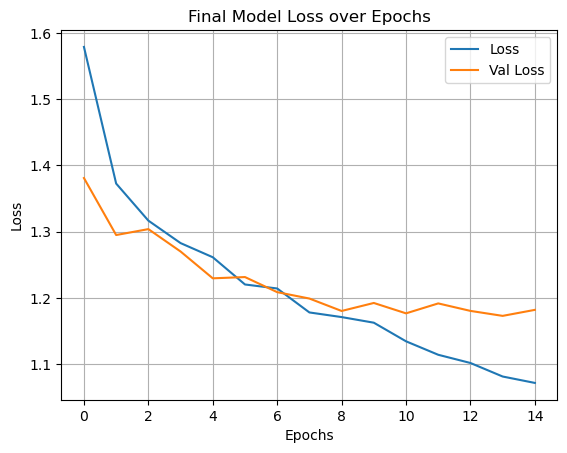

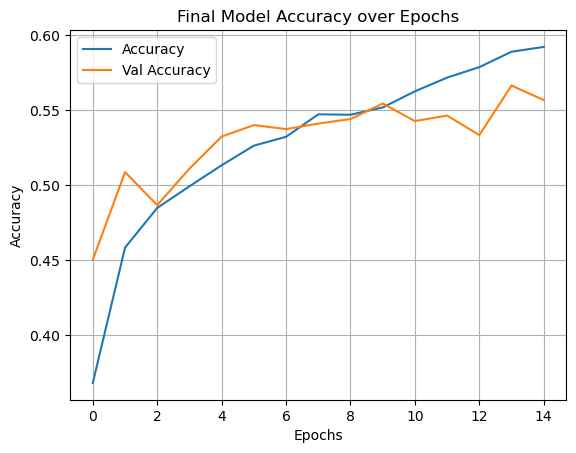

In [12]:
#Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#Plotting loss and validation loss
plt.plot(hist_final_model.history['loss'], label='Loss')
plt.plot(hist_final_model.history['val_loss'],label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Final Model Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

#Plotting accuracy and validation accuracy
plt.plot(hist_final_model.history['accuracy'], label='Accuracy')
plt.plot(hist_final_model.history['val_accuracy'],label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Final Model Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# saving the model for testing purposes
final_model.save("trained_MLP.h5")

94/94 [==============================] - 1s 9ms/step
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


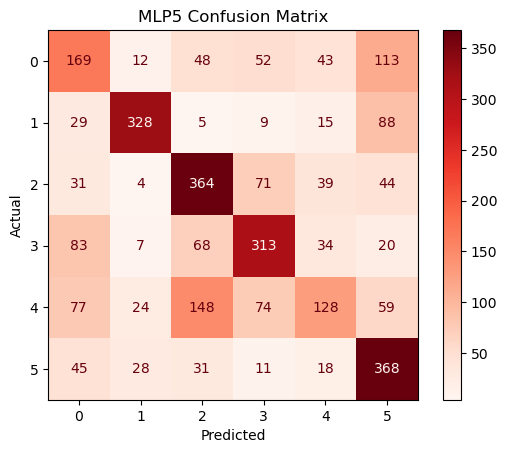

Prediction Shape: (3000,)
Test Shape: (3000,)
Num Samples in Matrix: 3000
Classification Report...
              precision    recall  f1-score   support

   buildings       0.39      0.39      0.39       437
      forest       0.81      0.69      0.75       474
     glacier       0.55      0.66      0.60       553
    mountain       0.59      0.60      0.59       525
         sea       0.46      0.25      0.33       510
      street       0.53      0.73      0.62       501

    accuracy                           0.56      3000
   macro avg       0.56      0.55      0.54      3000
weighted avg       0.56      0.56      0.55      3000

Total Accuracy: 0.5566666666666666


In [13]:
from sklearn.metrics import accuracy_score,classification_report

#get y prediction and class labels
y_pred = final_model.predict(Xtest)
y_pred_classes = np.argmax(y_pred, axis=1)
classes = []
for c in os.listdir(raw_dir_test):
    classes.append(c)

print("Classes:",classes)

#Confusion Matrix
cm = confusion_matrix(ytest, y_pred_classes)

matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot(cmap='Reds')
plt.title("MLP5 Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Prediction Shape:",y_pred_classes.shape)
print("Test Shape:",ytest.shape)
print("Num Samples in Matrix:",confusion_matrix(ytest,y_pred_classes).sum())

print("Classification Report...")
print(classification_report(ytest,y_pred_classes,target_names=classes))
print("Total Accuracy:",accuracy_score(ytest,y_pred_classes))